In [1]:
import scanpy as sc
import sys
sys.path.append("/home/zflu/multiomics")
adata_RNA = sc.read_h5ad('/home/zflu/Benchmark/strong/Dataset/10x-Multiome-Pbmc10k/10x-Multiome-Pbmc10k-RNA.h5ad')
adata_ATAC = sc.read_h5ad('/home/zflu/Benchmark/strong/Dataset/10x-Multiome-Pbmc10k/10x-Multiome-Pbmc10k-FRAGS2RNA.h5ad')

In [2]:
# 取交集基因并对齐
cm_genes = sorted(list(set(adata_ATAC.var_names) & set(adata_RNA.var_names)))
adata_RNA = adata_RNA[:, cm_genes]
adata_ATAC = adata_ATAC[:, cm_genes]

# 计算高变基因
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=1000)
sc.pp.highly_variable_genes(adata_ATAC, flavor='seurat_v3', n_top_genes=1000)

# 取共同的高变基因
shared_genes = adata_RNA.var_names[adata_RNA.var.highly_variable | adata_ATAC.var.highly_variable]
shared_genes = list(shared_genes)

adata_RNA = adata_RNA[:,shared_genes].copy()
adata_ATAC = adata_ATAC[:,shared_genes].copy()

sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)

sc.pp.normalize_total(adata_ATAC)
sc.pp.log1p(adata_ATAC)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}


In [3]:
import mycode
#mycode.utils.batch_scale(adata_RNA,method='standard')
#mycode.utils.batch_scale(adata_ATAC,method='standard')
sc.pp.scale(adata_RNA, max_value=10)
sc.pp.scale(adata_ATAC, max_value=10)

In [4]:
model = mycode.Model(adata_RNA, adata_ATAC, batch_size=500, 
                           training_steps=10000, seed=1234, celltype_col='cell_type',source_col=None,
                            n_latent=16, lambdaRecon = 10.0, lambdaLA = 10.0, 
                            lambdaOT = 1.0, lambdamGAN = 1.0, lambdabGAN = 1.0, n_KNN = 30, lambdaGeo=0.0, mode = 'strong', use_prior = False)

In [5]:
model.train()

Training started at: Tue Sep  2 16:01:37 2025
Step 0 | Recon: 18.4697 | LA: 46.8417 | OT: 15.4141 | Geo: 18.5205 | mGAN: -1.3617 | bGAN: -0.0000
Step 1000 | Recon: 13.2928 | LA: 0.0276 | OT: 0.1033 | Geo: 0.5154 | mGAN: -1.3856 | bGAN: -0.0000
Step 2000 | Recon: 13.0982 | LA: 0.0217 | OT: 0.0993 | Geo: 0.4397 | mGAN: -1.3815 | bGAN: -0.0000
Step 3000 | Recon: 12.9369 | LA: 0.0214 | OT: 0.1006 | Geo: 0.3806 | mGAN: -1.3861 | bGAN: -0.0000
Step 4000 | Recon: 12.8219 | LA: 0.0179 | OT: 0.0989 | Geo: 0.3640 | mGAN: -1.3767 | bGAN: -0.0000
Step 5000 | Recon: 12.9526 | LA: 0.0162 | OT: 0.0981 | Geo: 0.3553 | mGAN: -1.3823 | bGAN: -0.0000
Step 6000 | Recon: 12.6900 | LA: 0.0166 | OT: 0.0973 | Geo: 0.3375 | mGAN: -1.3842 | bGAN: -0.0000
Step 7000 | Recon: 12.8114 | LA: 0.0160 | OT: 0.1026 | Geo: 0.3223 | mGAN: -1.3813 | bGAN: -0.0000
Step 8000 | Recon: 12.5304 | LA: 0.0174 | OT: 0.0980 | Geo: 0.3375 | mGAN: -1.3856 | bGAN: -0.0000
Step 9000 | Recon: 12.4550 | LA: 0.0138 | OT: 0.1009 | Geo: 0.3

In [6]:
model.eval()

Evaluation started at: Tue Sep  2 16:14:00 2025
Evaluation completed at: Tue Sep  2 16:14:00 2025
Total evaluation time: 0.21 seconds
Processed 19262 samples
Latent space shape: (19262, 16)


In [7]:
import anndata as ad
import pandas as pd
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_RNA.obs, adata_ATAC.obs])
adata_integrated.obs['modality'] = ['RNA'] * adata_RNA.shape[0] + ['ATAC'] * adata_ATAC.shape[0]

In [8]:
sc.pp.neighbors(adata_integrated)
sc.tl.umap(adata_integrated, min_dist=0.3)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

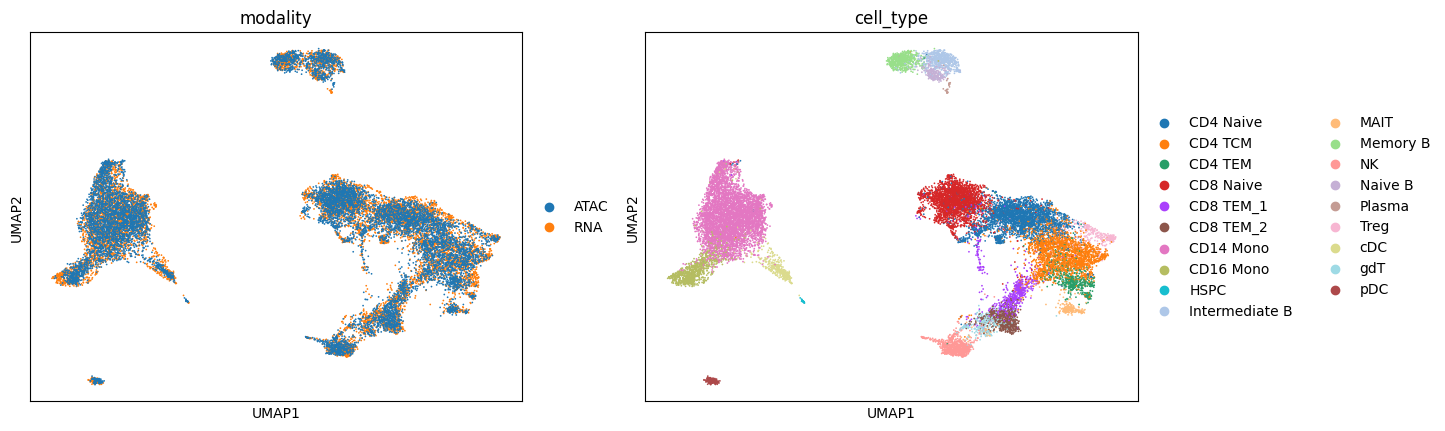

In [9]:
sc.pl.umap(adata_integrated, color=['modality','cell_type'])

In [12]:
import numpy as np
sc.pp.pca(adata_RNA)
sc.pp.pca(adata_ATAC)
X = model.latent
y = np.concatenate([adata_RNA.obsm['X_pca'], adata_ATAC.obsm['X_pca']], axis=0)
ct = pd.concat([adata_RNA.obs['cell_type'], adata_ATAC.obs['cell_type']]).to_numpy()
batch = np.array(['RNA']*adata_RNA.shape[0] + ['ATAC']*adata_ATAC.shape[0])
map_score = mycode.metrics.mean_average_precision(X, ct)
asw_celltype = mycode.metrics.avg_silhouette_width(X, ct)
nc = mycode.metrics.neighbor_conservation(X, y, batch)
asw_batch = mycode.metrics.avg_silhouette_width_batch(X, batch, ct)
sas = mycode.metrics.seurat_alignment_score(X, batch)
gc = mycode.metrics.graph_connectivity(X, batch)
foscttm = mycode.metrics.foscttm(X[:adata_RNA.shape[0],:], X[adata_RNA.shape[0]:,:])

print("MAP:", map_score)
print("ASW_celltype:", asw_celltype)
print("NC:", nc)
print("ASW_batch:", asw_batch)
print("SAS:", sas)
print("GC:", gc)
print("FOSCTTM:", foscttm)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/zflu/multiomics/mycode/metrics.py:290: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(c)


MAP: 0.8360967263468218
ASW_celltype: 0.5686586499214172
NC: 0.25278205697181816
ASW_batch: 0.924079179763794
SAS: 0.9272233499015216
GC: 0.9997923372443152
FOSCTTM: 0.06699235320875344
